In [1]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal
import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings

import tensorflow as tf


In [2]:
# RUN Utility functions

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.92
CUBE_SIZE = 250

# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image):
    temp = crop(image, Y_START, Y_END, X_START, X_END)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, Y_START+ymin, Y_START+ymax, X_START+xmin, X_START+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

#     import pdb; pdb.set_trace()
def calc_neighbors(slice_map, col, row):
    # import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    


def create_cube(raw, x, y):
    cube = {}
    cube["cube"] = raw
    cube["top_row"] = x
    cube["left_col"] = y
    cube["right_col"] = y + CUBE_SIZE
    return cube
    

ZERO_CUBE = create_cube(np.zeros((CUBE_SIZE, CUBE_SIZE), dtype=np.int), -1, -2)

# slice an image to cubes with 250X250 pixel size
def slice_to_static_slices(cropped_original):
    structure = {}
    cropped_original = cropped_original / 256 # divide by 256 to "normalize" between 0 and 1
    x, y = cropped_original.shape
    print (x,y)
    n = 0
    # every 250 pixels on the x axis == rows
    while ((n + 1) * CUBE_SIZE < x):
        m = 0
        # every 250 pixels on the y axis == cols
        while ((m + 1) * CUBE_SIZE < y):
            # cut a cube of 250X250
            cube = (crop(cropped_original, n * CUBE_SIZE, (n + 1) * CUBE_SIZE, m * CUBE_SIZE, (m + 1) * CUBE_SIZE))
            # keep only cubes for which half of the pixels have some "color"
            if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
                # keep the cube
                structure[(m, n)] = create_cube(cube, n * CUBE_SIZE, m * CUBE_SIZE)
                structure[(m, n)]["col"] = m
                structure[(m, n)]["row"] = n
            else:
                structure[(m, n)] = None
            m += 1
        n += 1
    
    # this loop has to be performed only after we've established all the None cubes
    for cube in structure.values():
        # set the reference to neighbor cubes
        if cube != None:
            calc_neighbors(structure, cube["col"], cube["row"])
        
    # return the data structure with all the cubes and the counters of the rows and columns
    return structure, m, n

def pad_above(original, above, amount):
    res = np.insert(original["cube"], np.zeros(amount), above["cube"][-amount:], axis=0)
    res = np.delete(res, np.arange(CUBE_SIZE,CUBE_SIZE+amount), axis=0)
    return create_cube(res, original["top_row"] - amount, original["left_col"])
  
def pad_below(original, below, amount):
    res = np.insert(original["cube"], np.full(amount, CUBE_SIZE), below["cube"][:amount], axis=0)
    res = np.delete(res, np.arange(0, amount), axis=0)
    return create_cube(res, original["top_row"] + amount, original["left_col"])

def pad_left(original, left, amount):
    res = np.insert(original["cube"], np.zeros(amount, dtype=int), left["cube"][:,-amount:], axis=1)
    res = np.delete(res, np.arange(CUBE_SIZE, CUBE_SIZE+amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] - amount)

def pad_right(original, right, amount):
    res = np.insert(original["cube"], [CUBE_SIZE], right["cube"][:,:amount], axis=1)
    res = np.delete(res, np.arange(0, amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] + amount)
    

# "Shave" the right edge of the cube with <gap> pixels and pad with zeros on the left
def shave_right(original, amount):
    return pad_left(original, ZERO_CUBE, amount)
    

# "Shave" the left edge of the cube with <gap> pixels and pad with zeros on the right    
def shave_left(original, amount):
    return pad_right(original, ZERO_CUBE, amount)
    

# concatenate cubes 
def concatenate_cubes(left, right):
    con = np.concatenate((left["cube"], right["cube"]), axis=1)
    x_delta = right["top_row"] - left["top_row"]
    y_delta = right["left_col"] - left["right_col"] 
    return con, x_delta, y_delta
    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cube with zeros
def concatenate_cubes_zero_pad_gaps(left_orig, right_orig, gap):
    left = left_orig if gap == 0 else shave_right(left_orig, gap)
    right = right_orig if gap == 0 else shave_left(right_orig, gap)
    return concatenate_cubes(left, right)    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cobe with the nearby
# continuation of the cubes
def concatenate_cubes_with_gap(left_orig, right_orig, gap, left_pad, right_pad):
    # import pdb; pdb.set_trace()
    left = left_orig if gap == 0 else pad_left(left_orig, left_pad, gap)
    right = right_orig if gap == 0 else pad_right(right_orig, right_pad, gap)
    return concatenate_cubes(left, right)        

# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def build_train_set(rows, cols, cubes, gap):
    # import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_lbls = []
    train_x_delta = []
    train_y_delta = []
    # iterate over the rows and cols, essentially going over the grid of sliced cubes
    for row in range(0, rows):
        for col in range(0, cols):
            # if this cube exists (could have been removed previously due to lack of data)
            if (cubes[(col, row)] != None):
                # for each "current" image in the iteration
                curr = cubes[(col, row)]
                # iterate over all the cubes to find all the "other" (adjacent) cubes
                for adj_row in range(0, rows):
                    for adj_col in range(0, cols):
                        if (adj_row != row or adj_col != col):
                            if (cubes[(adj_col, adj_row)] != None):
                                adj = cubes[(adj_col, adj_row)]
                                # append the adjacent image to the current image
                                # pass the filling cubes on the right and left to pad against the gap
                                if ("left" in curr.keys() and "right" in adj.keys()):
                                    conc, x_delta, y_delta = concatenate_cubes_with_gap(curr, adj, gap, curr["left"], adj["right"])
                                else:
                                    conc, x_delta, y_delta = concatenate_cubes(curr, adj)
                                train_imgs.append(conc)
                                train_x_delta.append(x_delta)
                                train_y_delta.append(y_delta)
                                # if the adj image is on the same row and on the right of the curr image - it will be marked as match    
                                if (adj_row == row and adj_col == (col + 1)):
                                    # mark the image as matched
                                    train_lbls.append([0,1])
                                    # need to enrich the set with a few more tru positive samples - so we offset 
                                    # the matched images up ad down a few times and create more matches
                                    if ("top" in curr.keys() and "top"in adj.keys()):
                                        for i in range(5, 101, 5):
                                            curr1 = pad_above(curr, curr["top"],i)
                                            adj1 = pad_above(adj, adj["top"],i)
                                            if ("left" in curr.keys() and "right" in adj.keys() and "top" in curr["left"].keys() and "top"in curr["right"].keys()):
                                                curr1Left = pad_above(curr["left"], curr["left"]["top"], i) # FIXIT?
                                                adj1Right = pad_above(adj["right"], curr["right"]["top"], i) # FIXIT?
                                                conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right)
                                            else:
                                                conc, x_delta, y_delta = concatenate_cubes(curr1, adj1)
                                            train_imgs.append(conc)
                                            train_x_delta.append(x_delta)
                                            train_y_delta.append(y_delta)
                                            # mark the image as matched
                                            train_lbls.append([0,1])
                                    if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                                        for i in range(5, 101, 5):
                                            curr1 = pad_below(curr, curr["bottom"],i)
                                            adj1 = pad_below(adj, adj["bottom"],i)
                                            if ("left" in curr.keys() and "right" in adj.keys() and "bottom" in curr["left"].keys() and "bottom"in curr["right"].keys()):
                                                curr1Left = pad_below(curr["left"], curr["left"]["bottom"], i) # FIXIT?
                                                adj1Right = pad_below(adj["right"], curr["right"]["bottom"], i) # FIXIT?
                                                conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right)
                                            else:
                                                conc, x_delta, y_delta = concatenate_cubes(curr1, adj1)
                                            train_imgs.append(conc)
                                            train_x_delta.append(x_delta)
                                            train_y_delta.append(y_delta)
                                            # mark the image as matched
                                            train_lbls.append([0,1])
                                    if ("left" in curr.keys()): # enough to check only the curr as the left of the adj is the curr
                                        for i in range(5, 101, 5):
                                            curr1 = pad_left(curr, curr["left"],i)
                                            adj1 = pad_left(adj, adj["left"],i) # essentially the curr
                                            if ("left" in curr.keys() and "right" in adj.keys()):
                                                curr1Left = pad_left(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                adj1Right = pad_left(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right)
                                            else:
                                                conc, x_delta, y_delta = concatenate_cubes(curr1, adj1)
                                            train_imgs.append(conc)
                                            train_x_delta.append(x_delta)
                                            train_y_delta.append(y_delta)
                                            # mark the image as matched
                                            train_lbls.append([0,1])
                                    if ("right" in adj.keys()): # enough to check only the adj as the right of the curr is the adj
                                        for i in range(5, 101, 5):
                                            curr1 = pad_right(curr, curr["right"],i) # essentially the adj
                                            adj1 = pad_right(adj, adj["right"],i)
                                            if ("left" in curr.keys() and "right" in adj.keys()):
                                                curr1Left = pad_right(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                adj1Right = pad_right(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right)
                                            else:
                                                conc, x_delta, y_delta = concatenate_cubes(curr1, adj1)
                                            train_imgs.append(conc)
                                            train_x_delta.append(x_delta)
                                            train_y_delta.append(y_delta)
                                            # mark the image as matched
                                            train_lbls.append([0,1])
                                else:
                                    # mark the image as not matched
                                    train_lbls.append([1,0])
                                
    warnings.filterwarnings("default")
    return train_imgs, train_lbls, train_x_delta, train_y_delta

In [3]:
# RUN Define more util functions

# initialize a shaped matrix of weights with random values
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# initialize a shaped matrix of bias with random values
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

def max_pool_5x5(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 5, 1],
                        strides=[1, 5, 5, 1], padding='SAME')


In [4]:
# RUN Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    


In [5]:
# RUN Define the model

# foundation of the model - the input layer of the image 250x500=125000
x = tf.placeholder(tf.float32, [None, 250, 500])
x_image = tf.reshape(x, [-1,250,500,1]) # 1 is the number of color channels

# the target digits of the model
y_ = tf.placeholder(tf.float32, [None, 2])

# first convolutional layer: one input image and 32 output filters of 5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250

# second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
W_conv2 = weight_variable([5, 5, 32, 32])
b_conv2 = bias_variable([32])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125

# third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
W_conv3 = weight_variable([5, 5, 32, 32])
b_conv3 = bias_variable([32])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*32]) # shape as an array 

# fourth layer - fully connected with input 25*25*128 and output 1024
W_fc1 = weight_variable([25*25*32, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

# a drop layer with probability 
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# final layer - softmax reduction 2 outputs
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# minimize loss function
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# define train step and rate
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# evaluate the prediction and the accuracy on the train test - needed only for printing during the training
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
def train(file, model):
    print("#####################################################################")
    print("TRAINING:"+file)
    print("MODEL:"+model)
    print("#####################################################################")

    # TRAIN Read the blue wave-length image and show it
    blue = read_and_crop(file) 

    # Show the relevant image
    plt.imshow(blue)

    cubes, cols, rows = slice_to_static_slices(blue)

    # TRAIN Build a labeled images list (match/no-match) corresponding the the labels list
    train_imgs, train_lbls, train_x_delta, train_y_delta = build_train_set(rows, cols, cubes, 0)
    len(train_imgs)

    # TRAIN split the original set randomly into a test set
    from random import randrange

    test_imgs = []
    test_lbls = []
    len_test = int(len(train_imgs) / 10)
    for _ in range(0, len_test):
            random_index = randrange(0,len(train_imgs))
            test_imgs.append(train_imgs.pop(random_index))
            test_lbls.append(train_lbls.pop(random_index))

    # train_set = DataSet(np.array(train_imgs), np.array(train_lbls))     
    len(test_imgs)

    # TRAIN Prepare the session

    # create a saver object
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())

    # TRAIN Train the model
    x_batch = []
    y_batch = []
    # run the train batches
    for i in range(400):
        x_batch = []
        y_batch = []
        for _ in range(50):
            random_index = randrange(0,len(train_imgs))
            x_batch.append(train_imgs[random_index])
            y_batch.append(train_lbls[random_index])

        # print the accuracy thus far
        if (i+1)%10 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:x_batch, y_: y_batch, keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        # train
        train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})

    train_accuracy = accuracy.eval(feed_dict={
        x:x_batch, y_: y_batch, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))

    # Save the variables to disk.
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)

    # Close the Session when we're done. If un-commented - need to run next bock of restore...
    sess.close()   
    print("#####################################################################")
    print("TRIANING ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")    

In [19]:
def validate(file, model, gap):
    print("#####################################################################")
    print("VALIDATING:"+file)
    print("GAP:"+str(gap))
    print("#####################################################################")
    
    # VALIDATE Read the blue wave-length VALIDATION image and show it
    blue = read_and_crop(file) 

    blue = blue[0:2500,0:3500]

    # Show the relevant image
    plt.imshow(blue)

    cubes, cols, rows = slice_to_static_slices(blue)

    # VALIDATE prepare the data sets
    test_imgs, test_lbls, test_x_delta, test_y_delta = build_train_set(rows, cols, cubes, gap)
    len(test_imgs)

    # VALIDATE Prepare a test session 

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()

    # Restore variables from disk.
    saver.restore(sess, model)
    print("Model restored.")

    # VALIDATE Validate the model

    # import pdb; pdb.set_trace()
    se = 0
    st = 0
    v1t = []
    v2t = []
    v1tt = []
    v2tt = []
    false_x_deltas = []
    false_y_deltas = []
    count = 0
    length = 10
    batch = 100
    # change the ranges in the loop below - first number is the start point (multiplied by batch size)
    # second number is the end point (multiplied by batch size)
    # third number is the jump from batch to batch
    # use the length about to set the batch length
    for start in range(0, 130, 20):
        print("Validating start at #%d end at %d"%(start*batch,(start+length)*batch))
        for i in range(start, start+length):
            x_batch = []
            y_batch = []
            row_delta_batch = []
            col_delta_batch = []
            for j in range(batch):
                x_batch.append(test_imgs[i*batch+j])
                y_batch.append(test_lbls[i*batch+j])
                row_delta_batch.append(test_x_delta[i*batch+j])
                col_delta_batch.append(test_y_delta[i*batch+j])


        #     my_prediction=tf.argmax(y_conv,1)
        #     my_target=tf.argmax(y_,1)
        #     print(my_prediction.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))
        #     print(my_target.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0}))

        # # print the accuracy thus far
        #     test_accuracy = accuracy.eval(feed_dict={
        #         x:x_batch, y_: y_batch, keep_prob: 1.0})
        # #     if (i+1)%10 == 0:
        #     print("step %d, validation accuracy %f"%(i, test_accuracy))

            my_prediction=tf.argmax(y_conv,1)
            my_target=tf.argmax(y_,1)
            v1 = my_prediction.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
            v2 = my_target.eval(feed_dict={x:x_batch, y_: y_batch, keep_prob: 1.0})
            v1t = np.concatenate((v1t, v1), axis=0)
            v2t = np.concatenate((v2t, v2), axis=0)

            c1 = np.sum(np.absolute(np.subtract(v2, v1)))
            c2 = np.sum(np.absolute(v2))
            se += c1
            st += c2

            false_guess_indexes = np.nonzero((v1-v2).clip(min=0))
            A = np.array(row_delta_batch)
            false_x_deltas = np.concatenate((false_x_deltas, A[false_guess_indexes]), axis=0)
            B = np.array(col_delta_batch)
            false_y_deltas = np.concatenate((false_y_deltas, B[false_guess_indexes]), axis=0)

        # print("predict=", v1t)
        # print("target =", v2t)
        count += ((i+1)*batch - start*batch)
        precision, recall, f_score, support = precision_recall_fscore_support(v2t, v1t, average='binary')
        print("step %d-%d, precision %f, recall %f, f_score %f"%(start, i, precision, recall, f_score))
        print("Accumulated total true = %d"%(st));
        print("Accumulated total error rate = %f"%(se/count));
        v1tt = np.concatenate((v1tt, v1t), axis=0)
        v2tt = np.concatenate((v2tt, v2t), axis=0)

    precision, recall, f_score, support = precision_recall_fscore_support(v2tt, v1tt, average='binary')
    print("TOTAL %d, precision %f, recall %f, f_score %f"%(count, precision, recall, f_score))
    print("TOTAL true = %d"%(st));
    print("TOTAL error rate = %f"%(se/count));

    plt.plot(false_x_deltas, false_y_deltas, "o")

    # Close the Session when we're done.
    sess.close()   
    print("#####################################################################")
    print("VALIDATION ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [20]:
def run_all(file_a, file_b, model):
    train(file_a, model)
    validate(file_b, model, 0)
    validate(file_b, model, 5)
    validate(file_b, model, 10)
    validate(file_b, model, 20)
    validate(file_b, model, 40)
    validate(file_b, model, 80)
    validate(file_b, model, 120)    

#####################################################################
TRAINING:PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112657-ML595__023.jpg
MODEL:/Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
#####################################################################
2282 4999
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 9, training accuracy 0.76
step 19, training accuracy 0.62
step 29, training accuracy 0.72
step 39, training accuracy 0.64
step 49, training accuracy 0.74
step 59, training accuracy 0.58
step 69, training accuracy 0.64
step 79, training accuracy 0.8
step 89, training accuracy 0.82
step 99, training accuracy 0.8
step 109, training accuracy 0.9
step 119, training accuracy 0.82
step 129, training accuracy 0.8
step 139, training accuracy 0.82
step 149, training accuracy 0.8
step 159, training accuracy 0.88
step 169, training accuracy 0.9
step 179, training accuracy 0.88
step 189, training accuracy 0.9
step 199, training ac

TypeError: Can't convert 'int' object to str implicitly

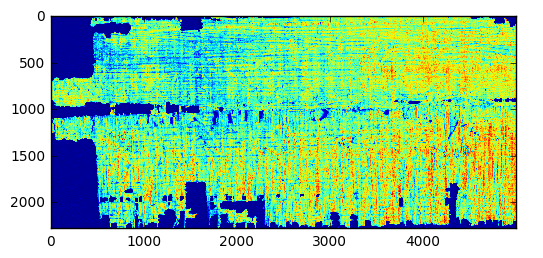

In [12]:
run_all("PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112657-ML595__023.jpg", "PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg", "/Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt")
run_all("PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112637-ML445__019.jpg", "PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120640-ML445__019.jpg", "/Users/il239838/Development/tf_tutorial/445_19_model400x50.ckpt")

#####################################################################
VALIDATING:PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg
GAP:0
#####################################################################
2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.430556, recall 0.870175, f_score 0.576074
Accumulated total true = 285
Accumulated total error rate = 0.365000
Validating start at #2000 end at 3000
step 20-29, precision 0.411290, recall 0.866038, f_score 0.557716
Accumulated total true = 530
Accumulated total error rate = 0.364000
Validating start at #4000 end at 5000
step 40-49, precision 0.434309, recall 0.865143, f_score 0.578304
Accumulated total true = 875
Accumulated total error rate = 0.368000
Validating start at #6000 end at 7000
step 60-69, precision 0.447092, recall 0.857475, f_score 0.587736
Accumulated total true = 1

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.417407, recall 0.824561, f_score 0.554245
Accumulated total true = 285
Accumulated total error rate = 0.378000
Validating start at #2000 end at 3000
step 20-29, precision 0.392175, recall 0.813208, f_score 0.529159
Accumulated total true = 530
Accumulated total error rate = 0.383500
Validating start at #4000 end at 5000
step 40-49, precision 0.410811, recall 0.781714, f_score 0.538583
Accumulated total true = 875
Accumulated total error rate = 0.390667
Validating start at #6000 end at 7000
step 60-69, precision 0.427205, recall 0.795507, f_score 0.555886
Accumulated total true = 1291
Accumulated total error rate = 0.410250
Validating start at #8000 end at 9000
step 80-89, precision 0.429334, recall 0.820036, f_score 0.563595
Accumulated total true = 1667
Accumulated total error rate = 0.423400
Valida

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.435514, recall 0.817544, f_score 0.568293
Accumulated total true = 285
Accumulated total error rate = 0.354000
Validating start at #2000 end at 3000
step 20-29, precision 0.399627, recall 0.807547, f_score 0.534666
Accumulated total true = 530
Accumulated total error rate = 0.372500
Validating start at #4000 end at 5000
step 40-49, precision 0.418861, recall 0.781714, f_score 0.545455
Accumulated total true = 875
Accumulated total error rate = 0.380000
Validating start at #6000 end at 7000
step 60-69, precision 0.439861, recall 0.784663, f_score 0.563717
Accumulated total true = 1291
Accumulated total error rate = 0.392000
Validating start at #8000 end at 9000
step 80-89, precision 0.437459, recall 0.809838, f_score 0.568062
Accumulated total true = 1667
Accumulated total error rate = 0.410600
Valida

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.457594, recall 0.814035, f_score 0.585859
Accumulated total true = 285
Accumulated total error rate = 0.328000
Validating start at #2000 end at 3000
step 20-29, precision 0.404103, recall 0.743396, f_score 0.523588
Accumulated total true = 530
Accumulated total error rate = 0.358500
Validating start at #4000 end at 5000
step 40-49, precision 0.406148, recall 0.709714, f_score 0.516639
Accumulated total true = 875
Accumulated total error rate = 0.387333
Validating start at #6000 end at 7000
step 60-69, precision 0.436482, recall 0.726569, f_score 0.545349
Accumulated total true = 1291
Accumulated total error rate = 0.391000
Validating start at #8000 end at 9000
step 80-89, precision 0.435637, recall 0.745051, f_score 0.549801
Accumulated total true = 1667
Accumulated total error rate = 0.406800
Valida

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.413310, recall 0.828070, f_score 0.551402
Accumulated total true = 285
Accumulated total error rate = 0.384000
Validating start at #2000 end at 3000
step 20-29, precision 0.376916, recall 0.788679, f_score 0.510067
Accumulated total true = 530
Accumulated total error rate = 0.401500
Validating start at #4000 end at 5000
step 40-49, precision 0.401961, recall 0.749714, f_score 0.523335
Accumulated total true = 875
Accumulated total error rate = 0.398333
Validating start at #6000 end at 7000
step 60-69, precision 0.423993, recall 0.758327, f_score 0.543889
Accumulated total true = 1291
Accumulated total error rate = 0.410500
Validating start at #8000 end at 9000
step 80-89, precision 0.418936, recall 0.775045, f_score 0.543885
Accumulated total true = 1667
Accumulated total error rate = 0.433400
Valida

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.408360, recall 0.891228, f_score 0.560088
Accumulated total true = 285
Accumulated total error rate = 0.399000
Validating start at #2000 end at 3000
step 20-29, precision 0.363484, recall 0.818868, f_score 0.503480
Accumulated total true = 530
Accumulated total error rate = 0.428000
Validating start at #4000 end at 5000
step 40-49, precision 0.368767, recall 0.769143, f_score 0.498519
Accumulated total true = 875
Accumulated total error rate = 0.451333
Validating start at #6000 end at 7000
step 60-69, precision 0.390119, recall 0.764524, f_score 0.516619
Accumulated total true = 1291
Accumulated total error rate = 0.461750
Validating start at #8000 end at 9000
step 80-89, precision 0.396636, recall 0.778044, f_score 0.525420
Accumulated total true = 1667
Accumulated total error rate = 0.468600
Valida

/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg'>
  self.load()


2500 3500
INFO:tensorflow:Restoring parameters from /Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt
Model restored.
Validating start at #0 end at 1000
step 0-9, precision 0.404762, recall 0.835088, f_score 0.545246
Accumulated total true = 285
Accumulated total error rate = 0.397000
Validating start at #2000 end at 3000
step 20-29, precision 0.351974, recall 0.807547, f_score 0.490263
Accumulated total true = 530
Accumulated total error rate = 0.445000
Validating start at #4000 end at 5000
step 40-49, precision 0.367257, recall 0.758857, f_score 0.494968
Accumulated total true = 875
Accumulated total error rate = 0.451667
Validating start at #6000 end at 7000
step 60-69, precision 0.391947, recall 0.738962, f_score 0.512215
Accumulated total true = 1291
Accumulated total error rate = 0.454250
Validating start at #8000 end at 9000
step 80-89, precision 0.394573, recall 0.758848, f_score 0.519187
Accumulated total true = 1667
Accumulated total error rate = 0.468600
Valida

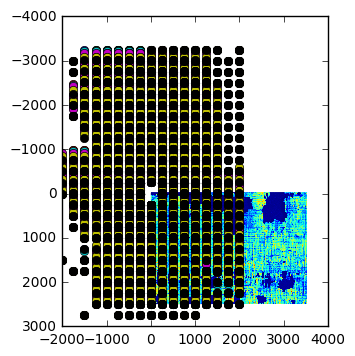

In [22]:
run_all("PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112657-ML595__023.jpg", "PX303/FG006/PX303-Fg006-V-C01-R01-D08032015-T120700-ML595__023.jpg", "/Users/il239838/Development/tf_tutorial/595_23_model400x50.ckpt")